<a href="https://colab.research.google.com/github/kamilo116/KNN/blob/master/KNN_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import os
import csv
import sys
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.transforms as transforms
import timeit

np.random.seed(4) 
torch.manual_seed(4) 
torch.cuda.manual_seed(4)

In [2]:
! git clone https://github.com/wang-chen/kervolution.git 

sys.path.append("kervolution/")
from kervolution import Kerv2d


Cloning into 'kervolution'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 53 (delta 2), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (53/53), done.


In [0]:
LIMIT_IMAGES_NUM = 1000
train_test_split_size = 0.2
image_resize = (100, 100)
batch_size = 64
num_workers = 0

out_1 = 16
out_2 = 32
out_3 = 64



k_size_1 = 3
padding_1 = 1
in_channels = 3

kernel_size = 3
num_epochs = 80

learning_rate = 0.0001
weight_decay = 0.2

MALIGNANT_DATASET = '/content/drive/My Drive/Colab_data/malignant/malignant/'
BENIGN_DATASET = '/content/drive/My Drive/Colab_data/benign/benign/'
DATA_FOLDER = '/content/drive/My Drive/Colab_data/'
model_backup_path = os.path.join(DATA_FOLDER, 'backup_model2') 
TRAIN_DATA_PER_CATEGORY = 101

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
benign_train_list = sorted(os.listdir(BENIGN_DATASET))[:LIMIT_IMAGES_NUM]
malignant_train_list = sorted(os.listdir(MALIGNANT_DATASET))[:LIMIT_IMAGES_NUM]

shuffle(benign_train_list)
shuffle(malignant_train_list)

test_benign_file_list = os.listdir(BENIGN_DATASET + 'test_set')[:TRAIN_DATA_PER_CATEGORY]
test_malignant_file_list = os.listdir(MALIGNANT_DATASET + 'test_set')[:TRAIN_DATA_PER_CATEGORY]
shuffle(test_benign_file_list)
shuffle(test_malignant_file_list)
print(f"Number of training benign {len(benign_train_list)} images")
print(f"Number of training malignant {len(malignant_train_list)} images")
print(f"Number of test benign {len(test_benign_file_list)} images")
print(f"Number of test malignant {len(test_malignant_file_list)} images")

data_transforms = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_transforms_test = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



Number of training benign 1000 images
Number of training malignant 1000 images
Number of test benign 101 images
Number of test malignant 101 images


In [0]:
class IsicDataset(Dataset):
    def __init__(self, data_folder, labeled_data, 
                 transform=transforms.Compose([transforms.ToTensor()]), datatype='train'):
        self.labeled_data = labeled_data
        self.transform = transform
        self.data_folder = data_folder
        self.datatype = datatype
        
        
    def __len__(self):
        return len(self.labeled_data)

    def __getitem__(self, index):
        label = self.labeled_data[index]
        test_set = ''
        if self.datatype == 'test':
          test_set = 'test_set' 
        if label == 0:
          image = Image.open(os.path.join(self.data_folder, "benign", "benign", test_set, index ))
        else:
          image = Image.open(os.path.join(self.data_folder, "malignant", "malignant", test_set, index ))
        image = self.transform(image)
        return image, label

    @property
    def labels(self):
      return self.labeled_data

In [0]:
avg_loss_list = []
acc_list = []

def prepare_dataset(benign_file_list, malignant_file_list, transform, datatype='train'):
  benign_dict = {filename: 0 for filename in benign_file_list}
  malignant_dict = {filename: 1 for filename in malignant_file_list}
  img_class_dict = {**benign_dict , **malignant_dict}
  labeled_data = pd.Series(img_class_dict)

  dataset = IsicDataset(DATA_FOLDER, labeled_data, transform=transform, datatype=datatype)
  print(dataset.labels)
  return dataset

def train(model, train_loader ,loss_fn, optimizer, num_epochs=1, starting_from_epoch=1):
    total_loss =0

    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        for t, (x, y) in enumerate(train_loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            total_loss += loss.data
            
            if (t + 1) % print_every == 0:
                avg_loss = total_loss/print_every
                print('t = %d, avg_loss = %.4f' % (t + 1, avg_loss) )
                avg_loss_list.append(avg_loss)
                total_loss = 0
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc = check_accuracy(model_gpu, valid_loader)
        print('acc = %f' %(acc))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_gpu.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'acc_list': acc_list,
            }, model_backup_path)
            
def check_accuracy(model, loader, datatype='train'):
    print(f'Checking accuracy on {datatype} set')   
    num_correct = 0
    num_samples = 0
    model.eval() 
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if datatype is 'train':
      acc_list.append(acc)
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
    
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)  
        

In [8]:
train_dataset = prepare_dataset(benign_train_list, malignant_train_list, data_transforms)

X_train, X_valid = train_test_split(train_dataset.labels, test_size=train_test_split_size)

print("number of training data: ",len(X_train))
print("number of valid  data: ",len(X_valid))

train_sampler = SubsetRandomSampler(list(X_train.index))
valid_sampler = SubsetRandomSampler(list(X_valid.index))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)


ISIC_0000496.jpeg    0
ISIC_0001026.jpeg    0
ISIC_0002904.jpeg    0
ISIC_0001833.jpeg    0
ISIC_0001397.jpeg    0
                    ..
ISIC_0010792.jpeg    1
ISIC_0010174.jpeg    1
ISIC_0013316.jpeg    1
ISIC_0015166.jpeg    1
ISIC_0013652.jpeg    1
Length: 2000, dtype: int64
number of training data:  1600
number of valid  data:  400


In [9]:
test_dataset = prepare_dataset(test_benign_file_list, test_malignant_file_list, data_transforms_test, datatype='test')
test_part, _ = train_test_split(test_dataset.labels, test_size=1)
test_sampler = SubsetRandomSampler(list(test_part.index))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, sampler=test_sampler, num_workers=num_workers)

ISIC_0002800.jpeg    0
ISIC_0000763.jpeg    0
ISIC_0001338.jpeg    0
ISIC_0001480.jpeg    0
ISIC_0000747.jpeg    0
                    ..
ISIC_0000156.jpeg    1
ISIC_0015124.jpeg    1
ISIC_0011780.jpeg    1
ISIC_0014735.jpeg    1
ISIC_0001142.jpeg    1
Length: 202, dtype: int64


In [10]:
print_every = 5
gpu_dtype = torch.cuda.FloatTensor


'''
Kerv2d
kervolution with following options:
kernel_type: [linear, polynomial, gaussian, etc.]
default is convolution:
          kernel_type --> linear,
balance, power, gamma is valid only when the kernel_type is specified
if learnable_kernel = True,  they just be the initial value of learable parameters
if learnable_kernel = False, they are the value of kernel_type's parameter
the parameter [power] cannot be learned due to integer limitation
dilation (int or tuple, optional): Spacing between kernel
elements. Default: 1
groups (int, optional): Number of blocked connections from input
channels to output channels. Default: 1
bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
kernel_type (str), Default: 'linear'
learnable_kernel (bool): Learnable kernel parameters.  Default: False 
balance: 0, 1
power: 3, 4, 5
gamma:
'''

model_base = nn.Sequential( 
                #nn.Conv2d(in_channels , out_1, padding= padding_1, kernel_size=k_size_1, stride=1),
                nn.Kerv2d(in_channels , out_1, padding=padding_1, bias=True, 
                          kernel_type='gaussian', kernel_size=3, learnable_kernel=True,
                          kernel_regularizer=True, stride=1, gamma=0.75
                          ), 
                #nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_1),
                nn.AvgPool2d(2, stride=2),
                nn.Conv2d(out_1 , out_2, padding= padding_1, kernel_size=3, stride=1), 
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_2),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(out_2 , out_3, padding= padding_1, kernel_size=3, stride=1),  
                
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_3),
                nn.MaxPool2d(2, stride=2),
               
                nn.Dropout(0.5),
                Flatten(),
                nn.Linear(9216,64),

                nn.ReLU(inplace=True),
                nn.Linear(64,2)
            )
model_gpu = model_base.type(gpu_dtype)
print(model_gpu)
loss_fn = nn.modules.loss.CrossEntropyLoss()
optimizer = optim.Adam(model_gpu.parameters(), lr = learning_rate, weight_decay=weight_decay)

Sequential(
  (0): Kerv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.5, inplace=False)
  (12): Flatten()
  (13): Linear(in_features=9216, out_features=64, bias=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
train(model_gpu, train_loader ,loss_fn, optimizer, num_epochs=num_epochs)


Starting epoch 1 / 80
t = 5, avg_loss = 0.6352
t = 10, avg_loss = 0.6077
t = 15, avg_loss = 0.6293
t = 20, avg_loss = 0.5191
t = 25, avg_loss = 0.5535
Checking accuracy on train set
Got 217 / 400 correct (54.25)
acc = 0.542500
Starting epoch 2 / 80
t = 5, avg_loss = 0.5032
t = 10, avg_loss = 0.5018
t = 15, avg_loss = 0.4877
t = 20, avg_loss = 0.5174
t = 25, avg_loss = 0.5104
Checking accuracy on train set
Got 310 / 400 correct (77.50)
acc = 0.775000
Starting epoch 3 / 80
t = 5, avg_loss = 0.4712
t = 10, avg_loss = 0.4187
t = 15, avg_loss = 0.4741
t = 20, avg_loss = 0.5230
t = 25, avg_loss = 0.5231
Checking accuracy on train set
Got 314 / 400 correct (78.50)
acc = 0.785000
Starting epoch 4 / 80
t = 5, avg_loss = 0.4636
t = 10, avg_loss = 0.4616
t = 15, avg_loss = 0.4468
t = 20, avg_loss = 0.4348
t = 25, avg_loss = 0.4921
Checking accuracy on train set
Got 325 / 400 correct (81.25)
acc = 0.812500
Starting epoch 5 / 80
t = 5, avg_loss = 0.4457
t = 10, avg_loss = 0.4402
t = 15, avg_loss = 

In [0]:
check_accuracy(model_gpu, test_loader, datatype='test')

In [0]:
def plot_accurancy(acc_list):
  plt.plot([i+1 for i in range((len(acc_list)))],acc_list)
  print("Accurancy:")
  plt.show()

def plot_loss_function(avg_loss_list):
  plt.plot([print_every*batch_size*(i+1) for i in range((len(avg_loss_list)))],avg_loss_list)
  print("Loss:")
  plt.show()

In [0]:
#plot_accurancy(acc_list)
#plot_loss_function(avg_loss_list)

In [0]:
def retry_from_backup():
  model_gpu = model_base.type(gpu_dtype)
  print(model_gpu)
  loss_fn = nn.modules.loss.CrossEntropyLoss()
  optimizer = optim.Adam(model_gpu.parameters(), lr = learning_rate, weight_decay=weight_decay) 

  checkpoint = torch.load(model_backup_path)
  model_gpu.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  acc_list = checkpoint['acc_list']
  #avg_loss_list = checkpoint['avg_loss_list']
  print("starting from epoch: " + str(epoch))
  print("starting from loss: " + str(loss))
  print(acc_list)
  
  
  train(model_gpu, train_loader ,loss_fn, optimizer, num_epochs=20, starting_from_epoch=epoch)
  check_accuracy(model_gpu, valid_loader)

  plot_accurancy(acc_list)
  plot_loss_function(avg_loss_list)


In [16]:
retry_from_backup()

Sequential(
  (0): Kerv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.5, inplace=False)
  (12): Flatten()
  (13): Linear(in_features=9216, out_features=64, bias=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=64, out_features=2, bias=True)
)
starting from epoch: 79
starting fr

KeyboardInterrupt: ignored

Accurancy:


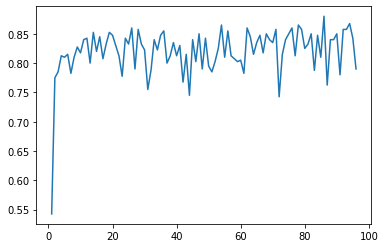

Loss:


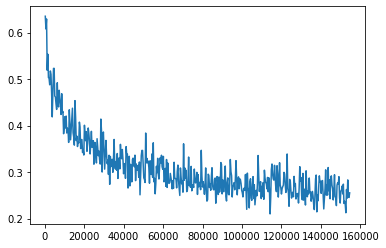

In [17]:
plot_accurancy(acc_list)
plot_loss_function(avg_loss_list)

In [18]:
check_accuracy(model_gpu, test_loader, datatype='test')

Checking accuracy on test set
Got 169 / 201 correct (84.08)


0.8407960199004975

In [19]:
print(acc_list)

[0.5425, 0.775, 0.785, 0.8125, 0.81, 0.815, 0.7825, 0.81, 0.8275, 0.8175, 0.84, 0.8425, 0.8, 0.8525, 0.82, 0.845, 0.8075, 0.8325, 0.8525, 0.8475, 0.83, 0.8125, 0.7775, 0.8425, 0.8325, 0.86, 0.79, 0.8575, 0.8325, 0.8225, 0.755, 0.7875, 0.84, 0.8225, 0.8475, 0.855, 0.8, 0.8125, 0.835, 0.8125, 0.83, 0.7675, 0.815, 0.745, 0.84, 0.8025, 0.85, 0.79, 0.8425, 0.795, 0.785, 0.8025, 0.825, 0.865, 0.81, 0.855, 0.8125, 0.8075, 0.8025, 0.805, 0.7825, 0.86, 0.845, 0.815, 0.835, 0.8475, 0.8175, 0.85, 0.84, 0.835, 0.8575, 0.7425, 0.815, 0.84, 0.85, 0.86, 0.8125, 0.865, 0.8575, 0.825, 0.8325, 0.85, 0.7875, 0.8475, 0.81, 0.88, 0.7625, 0.84, 0.84, 0.85, 0.78, 0.8575, 0.8575, 0.8675, 0.8425, 0.79]
